### Llamada a las funciones del notebook

Imágenes 2D.

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output
import numpy as np
import os
import cv2
from skimage.filters import sato

# Visualizar imágenes
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:] + alpha*moving[:,:] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

### Cargar imágenes y inicializar

Cambiar la ruta establecida donde se tengan guardadas las imágenes, inicializamos la transformada y visualizamos de donde parte nuestro alineamiento. Utilizamos el filtro de sato para segmentar los vasos.

In [2]:
os.chdir("images/")

In [3]:
# Cargar las imágenes y las máscaras a utilizar
fixed_image = []
fixed_image_real = []
moving_image = []
moving_image_real = []
mask1 = []
mask2 = []

for a in ("A", "C", "D"):
    fixed_image_real.append(sitk.ReadImage((a + "1.png"), sitk.sitkFloat32))
    moving_image_real.append(sitk.ReadImage((a + "2.png"), sitk.sitkFloat32))

    mask1.append(sitk.ReadImage((a + "1_mask.png"), sitk.sitkFloat32))
    mask2.append(sitk.ReadImage((a + "2_mask.png"), sitk.sitkFloat32))
    
    # Imágenes segmentadas para calcular las transformaciones utilizando los vasos
    fix_image = cv2.imread(a + "1.png", 0)
    moved_image = cv2.imread(a + "2.png", 0)
    fix_image = cv2.bilateralFilter(fix_image,39,75,75) # Eliminamos ruido y vasos pequeños que no se encuentrarn en el otro tipo de imagen
    sato_i = sato(fix_image, black_ridges=False).astype(np.float32)
    sato_i2 = sato(moved_image).astype(np.float32)
    fixed_image.append(sitk.GetImageFromArray(sato_i))
    moving_image.append(sitk.GetImageFromArray(sato_i2))

    
# Inicializar la primera transformada
initial_transform = []
for i in range(0,3):
    initial_transform.append(sitk.CenteredTransformInitializer(fixed_image[i], 
                                                          moving_image[i],
                                                          sitk.Euler2DTransform(),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY))
    
    moving_resampled = sitk.Resample(moving_image[i], fixed_image[i], initial_transform[i], sitk.sitkLinear, 0.0, moving_image[i].GetPixelID())

    interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image_real[i]), moving=fixed(moving_image_real[i]));
    interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image[i]), moving=fixed(moving_resampled));

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

### Funciones de registro y registro para demons

In [4]:
def registro(fixed_image, moving_image, initial_transform, mask1, mask2, interpolator):
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    #registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    #registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(interpolator)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=200, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Poniendo máscaras para usar
    registration_method.SetMetricFixedMask(mask1)
    registration_method.SetMetricMovingMask(mask2)
    
    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                   sitk.Cast(moving_image, sitk.sitkFloat32))

    return final_transform, registration_method.GetMetricValue()


def smooth_and_resample(image, shrink_factors, smoothing_sigmas):
    if np.isscalar(shrink_factors):
        shrink_factors = [shrink_factors]*image.GetDimension()
    if np.isscalar(smoothing_sigmas):
        smoothing_sigmas = [smoothing_sigmas]*image.GetDimension()

    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigmas)
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(sz/float(sf) + 0.5) for sf,sz in zip(shrink_factors,original_size)]
    new_spacing = [((original_sz-1)*original_spc)/(new_sz-1) 
                   for original_sz, original_spc, new_sz in zip(original_size, original_spacing, new_size)]
    return sitk.Resample(smoothed_image, new_size, sitk.Transform(), 
                         sitk.sitkLinear, image.GetOrigin(),
                         new_spacing, image.GetDirection(), 0.0, 
                         image.GetPixelID())


    
def multiscale_demons(registration_algorithm,
                      fixed_image, moving_image, initial_transform = None, 
                      shrink_factors=None, smoothing_sigmas=None):
    
    # Create image pyramid.
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    if shrink_factors:
        for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
            fixed_images.append(smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma))
            moving_images.append(smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma))
    
    # Create initial displacement field at lowest resolution. 
    # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(initial_transform, 
                                                                       sitk.sitkVectorFloat64,
                                                                       fixed_images[-1].GetSize(),
                                                                       fixed_images[-1].GetOrigin(),
                                                                       fixed_images[-1].GetSpacing(),
                                                                       fixed_images[-1].GetDirection())
    else:
        initial_displacement_field = sitk.Image(fixed_images[-1].GetWidth(), 
                                                fixed_images[-1].GetHeight(),
                                                fixed_images[-1].GetDepth(),
                                                sitk.sitkVectorFloat64)
        initial_displacement_field.CopyInformation(fixed_images[-1])
 
    # Run the registration.            
    initial_displacement_field = registration_algorithm.Execute(fixed_images[-1], 
                                                                moving_images[-1], 
                                                                initial_displacement_field)
    # Start at the top of the pyramid and work our way down.    
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = registration_algorithm.Execute(f_image, m_image, initial_displacement_field)
    return sitk.DisplacementFieldTransform(initial_displacement_field)

### Ejecutar el algortimo de registro con las diferentes opciones consideradas


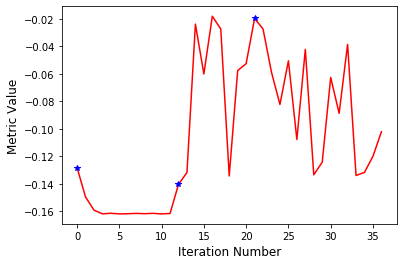

In [5]:
transforms = []
interpoladores = [sitk.sitkLinear, sitk.sitkCosineWindowedSinc]
nombres = ["Linear", "CosineWindow"]
metri = []
stop_c = []

for i in range(0,3):
    for a in interpoladores:
        final_transform, metric_va = registro(fixed_image[i], moving_image[i], initial_transform[i], mask1[i], mask2[i], a)
        transforms.append(final_transform)
        metri.append(metric_va)

In [6]:
# Prints de los valores finales en las métricas
print("Interpolator      ", nombres * 3)
print("Final metric value", metri)

Interpolator       ['Linear', 'CosineWindow', 'Linear', 'CosineWindow', 'Linear', 'CosineWindow']
Final metric value [-0.07435889924891222, -0.07520642996411254, -0.008931267202064464, -0.06152260081753831, -0.13296411729988702, -0.05351374247725617]


### Registros finales obtenidos

Solo para modelos de transformaciones rígidas

In [7]:
moving_resampled2 = []
con = 0
cuen = 0

for i in range(0,len(transforms)):
    movi = sitk.Resample(moving_image_real[cuen], fixed_image_real[cuen], transforms[i], interpoladores[con], 0.0, moving_image_real[cuen].GetPixelID())
    moving_resampled2.append(movi)
    print(nombres[con])
    interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image_real[cuen]), moving=fixed(movi))
    if con == 1:
        cuen += 1
    con += 1
    if con == 2:
        con = 0

Linear


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

CosineWindow


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

Linear


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

CosineWindow


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

Linear


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

CosineWindow


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

### Ejecución para el Demon

In [8]:
# Select a Demons filter and configure it.
demons_filter =  sitk.DiffeomorphicDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(20)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(2.0)

# Alineamiento no rígido
final_tfm = []
con = 0
for i in range(0,len(transforms),2):
    # Run the registration.
    final_tfm.append(multiscale_demons(registration_algorithm=demons_filter, 
                                  fixed_image = fixed_image[con],
                                  moving_image = moving_image[con],
                                  initial_transform = initial_transform[con],
                                  shrink_factors = [6,4,2],
                                  smoothing_sigmas = [6,4,2]))
    con += 1

### Registro final obtenido con Demon

In [9]:
a = 0
for i in range(0,len(final_tfm)):
    a = (i * 2)
    if i == 0:
        a = 0
    print(a)
    movi_final = sitk.Resample(moving_image_real[i], fixed_image_real[i], final_tfm[i], interpoladores[1], 0.0, moving_image_real[i].GetPixelID())
    interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image_real[i]), moving=fixed(movi_final))

0


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

2


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

4


interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…